# Librerias

In [2]:
import tensorflow
import pathlib

import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

# Modelo de redes Densas

In [2]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(128, 128, 3)) 

x=model_d.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(1,activation='sigmoid')(x) #FC-layer

In [4]:
model=Model(inputs=model_d.input,outputs=preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']         

En vista a solucionar overfitting, se procede a desactivar las últimas 8 capas del modelo, las cuales se centran en la detección de bordes y manchas en las imágenes. Estas capas podrán ser activadas de nuevo una vez el modelo sea entrenado, con esto conseguiremos evitar el overfitting. 

In [5]:
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

In [6]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']         

# Conexion con Cloud

In [3]:
from google.colab import drive
drive.mount('/content/drive')

project_id = 'angelic-cat-338018'
!gcloud config set project {project_id}

#Conexion Cloud
from google.colab import auth
auth.authenticate_user()

Mounted at /content/drive
Updated property [core/project].


In [4]:
import tensorflow as tf
dataset_url = "https://storage.googleapis.com/tfmbucket1/images/train/Dataset_bin_min.tar"
data_dir = tf.keras.utils.get_file('Dataset', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

85188608/85177856 [==============================] - 1s 0us/step


El repositorio de imagenes contiene:  18000  elementos


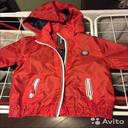

In [5]:
import PIL
image_count = len(list(data_dir.glob('*/*.jpg')))
print("El repositorio de imagenes contiene: ", image_count, " elementos")

appliances = list(data_dir.glob('0/*'))
PIL.Image.open(str(appliances[1]))
#18000 

In [6]:
data=[]
labels=[]
random.seed(42)
imagePaths = sorted(list(os.listdir(data_dir)))
random.shuffle(imagePaths)
print(imagePaths)

['1', '0']


In [7]:
for img in imagePaths:
    path=sorted(list(os.listdir("/root/.keras/datasets/Dataset/"+img))) 
    for i in path:
        image = cv2.imread("/root/.keras/datasets/Dataset/"+img+'/'+i)
        image = cv2.resize(image, (128,128))
        image = img_to_array(image)
        data.append(image)
        l = label = img
        labels.append(l)

Labels

In [8]:
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
mlb = LabelBinarizer()
labels = mlb.fit_transform(labels)
print(labels[0])

[1]


Train Test

In [9]:
(xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.3,random_state=42)
print(xtrain.shape, xtest.shape)

(12600, 128, 128, 3) (5400, 128, 128, 3)


Si el modelo no ve ningún cambio en la pérdida de validación, la función ReduceLROnPlateau reducirá la tasa de aprendizaje, lo que a menudo beneficia al modelo. La función ImageDataGenerator realiza un aumento de datos en tiempo real sobre lotes de datos de imagen de tensor generados en un bucle.

In [14]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)

datagen.fit(xtrain)

# Entrenamos Modelo

In [15]:
# Fits-the-model
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=128),
               steps_per_epoch=xtrain.shape[0] //128,
               epochs=50,
               verbose=2,
               callbacks=[anne, checkpoint],
               validation_data=(xtrain, ytrain))

Epoch 1/50

Epoch 1: val_loss improved from inf to 0.67670, saving model to model.h5
98/98 - 122s - loss: 0.9277 - accuracy: 0.5358 - val_loss: 0.6767 - val_accuracy: 0.6000 - lr: 0.0010 - 122s/epoch - 1s/step
Epoch 2/50

Epoch 2: val_loss improved from 0.67670 to 0.65433, saving model to model.h5
98/98 - 92s - loss: 0.7460 - accuracy: 0.5618 - val_loss: 0.6543 - val_accuracy: 0.6196 - lr: 0.0010 - 92s/epoch - 943ms/step
Epoch 3/50

Epoch 3: val_loss improved from 0.65433 to 0.63732, saving model to model.h5
98/98 - 92s - loss: 0.6869 - accuracy: 0.5920 - val_loss: 0.6373 - val_accuracy: 0.6359 - lr: 0.0010 - 92s/epoch - 944ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.63732 to 0.62711, saving model to model.h5
98/98 - 92s - loss: 0.6684 - accuracy: 0.6031 - val_loss: 0.6271 - val_accuracy: 0.6487 - lr: 0.0010 - 92s/epoch - 934ms/step
Epoch 5/50

Epoch 5: val_loss did not improve from 0.62711
98/98 - 96s - loss: 0.6597 - accuracy: 0.6112 - val_loss: 0.6281 - val_accuracy: 0.651

In [16]:
#Guardar modelo
#model.save('/content/modelo3', save_format = 'h5')
#!gsutil cp -r /content/modelo3 gs://tfmbucket1/models

Copying file:///content/modelo3 [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/46.1 MiB.                                     


In [1]:
#Cargar el modelo
from tensorflow.keras.models import Sequential, load_model
# Importing saved model
output_dir =  '/content/'
model = load_model(output_dir + 'modelo3')

In [10]:
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 5400 	accurately-predicted-data: 5400 	 wrongly-predicted-data:  0
Accuracy: 100.0 %


# Testeamos Modelo

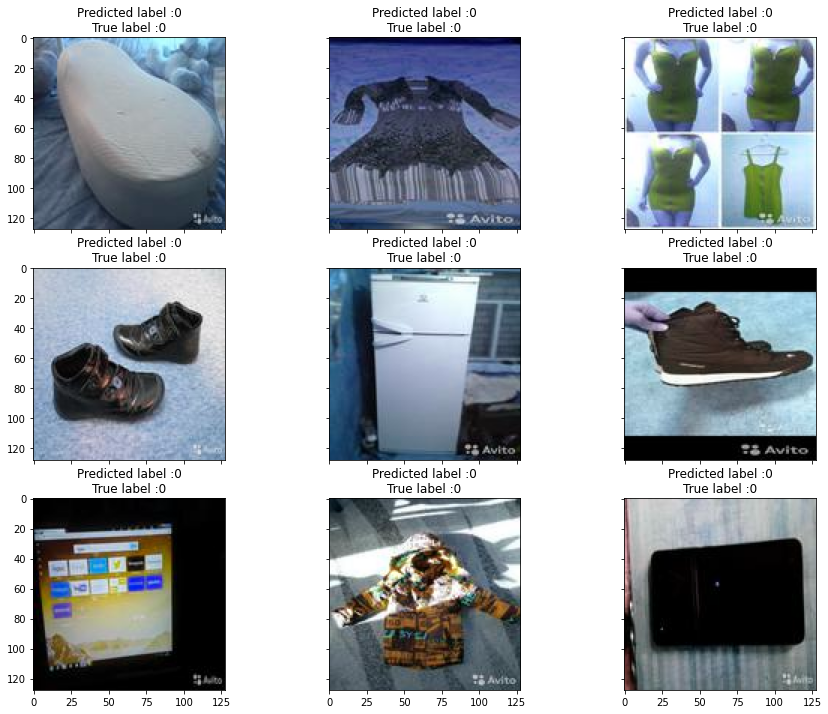

In [11]:
label = ["0","1"]
         
imidx = random.sample(accurateindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()

Text(0.5, 145.31999999999996, 'Predicted')

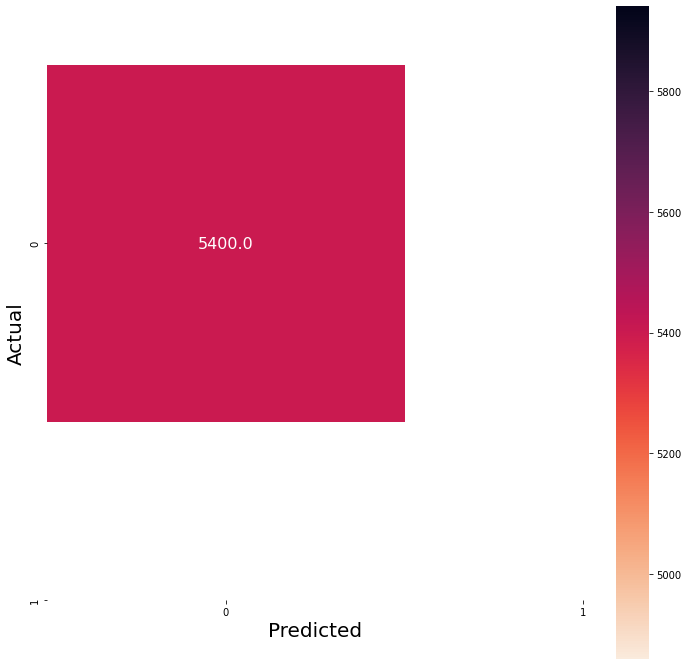

In [12]:
Ypred = model.predict(xtest)

Ypred = np.argmax(Ypred, axis=1)
Ytrue = np.argmax(ytest, axis=1)

cm = confusion_matrix(Ytrue, Ypred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

# Ejecutamos Modelo con una muestra

In [ ]:
#Ejecutar modelo
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
import keras
import cv2
import numpy as np

modelo_imgcat = keras.models.load_model('/content/drive/MyDrive/TFM Big Data & BA/Propuestas/Proyecto Final/4 - Deep Learning/Modelos H5/Categorizacion_DenseNet201')
imagen = cv2.imread('/content/drive/MyDrive/TFM Big Data & BA/Propuestas/Proyecto Final/0 - Imagenes/ejemplo.jpg')

imagen = cv2.resize(imagen, (224, 224), interpolation=cv2.INTER_LINEAR)
imagen = np.asarray(imagen).reshape((1, 224, 224, 3))
y_prob = modelo_imgcat.predict(imagen)
y_classes = y_prob.argmax(axis = -1)